In [11]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from model import YModel

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

## Toy model

Input X - corresponds to any kind of phase space input - some **distribution** with prior.
Input $\mu$ - corresponds to parameters of surrogate, ie - size of detector, magnetic field, etc. - a **number**.

Define some functions f, g - those can be varied. Probably, bettern to stick with some types of them, ie:
continous, pereodic, polynomial, ...


$$X \sim U(x_{min}, x_{max}), \ \ \mu \sim \delta(\mu - \mu_0) $$

$$latent\_x \sim  \mathcal{N} (latent\_x | X, 1)$$


$$ f(\alpha) = a + b \alpha  $$
$$ g(\alpha) = d * \alpha $$

$$y \sim \mathcal{N}(y|f(latent\_x) + g(\mu), 1)$$

### Problem statement

1. Fit GAN/GP/NV to match p(y|X,mu)

2. Solve optimisaiton problem of the choise:
 - $argmin_{mu} (y - Y_0) ^2 $
 - $argmax_{mu} p(y|mu) = \int p(y|X,mu) p(X) dx$
 - $etc$



## Make model with `pyro`


## Investigation of the model

In [12]:
y_sampler = YModel()

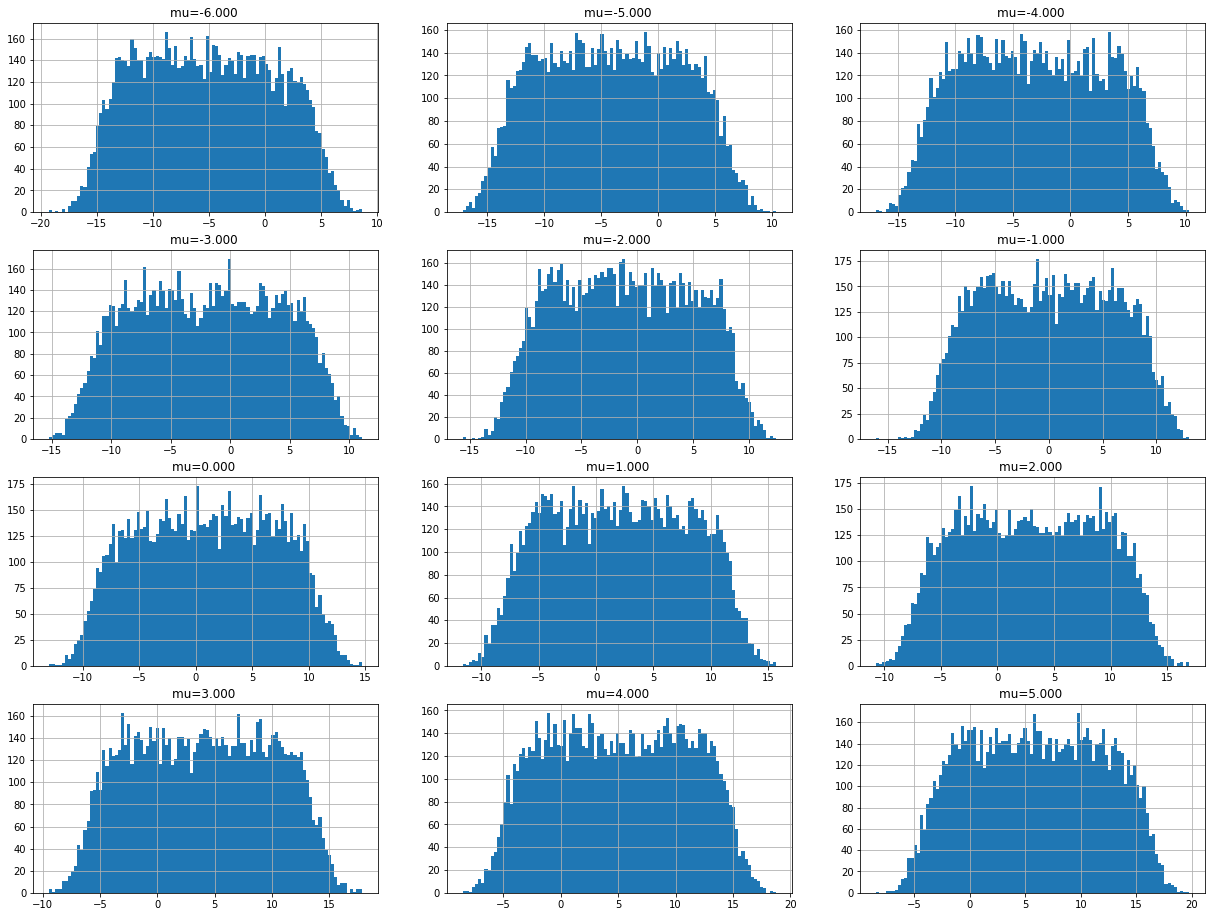

In [13]:
plt.figure(figsize=(21,16))
mu = list(range(-6, 6, 1))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        y_sampler.make_condition_sample({'mu': torch.tensor([float(mu[i*3 + j])] * 10000)})
        plt.hist(y_sampler.condition_sample().detach().numpy(), bins=100);
        plt.grid()
        #plt.legend()
        plt.title("mu={:.3f} ".format(mu[i*3 + j]))

CPU times: user 972 ms, sys: 36 ms, total: 1.01 s
Wall time: 1.01 s


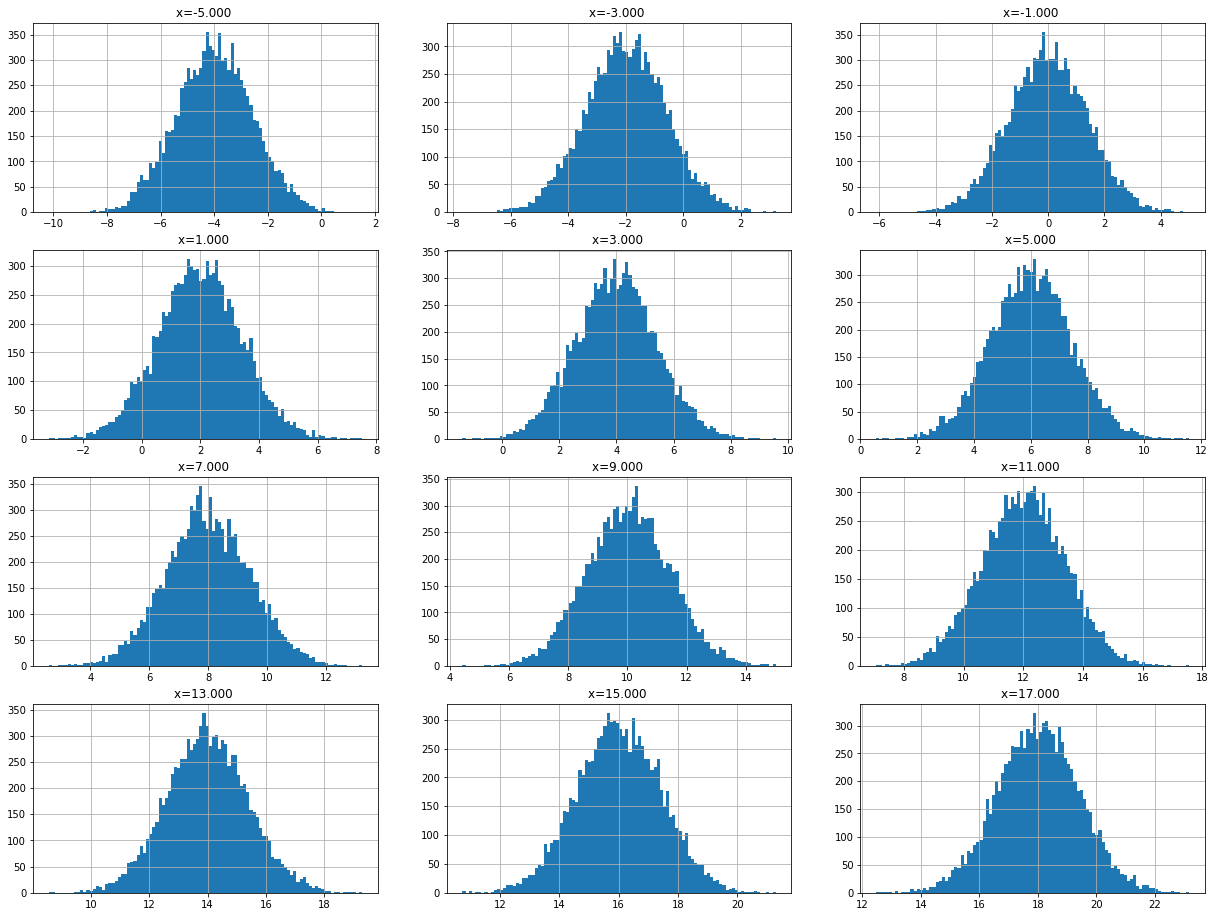

In [14]:
%%time
plt.figure(figsize=(21,16))
x_r = list(range(-5, 18, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        y_sampler.make_condition_sample({'X': torch.tensor([float(x_r[i*3 + j])] * 10000)})
        plt.hist(y_sampler.condition_sample(10000).detach().numpy(), bins=100);
        plt.grid()
        #plt.legend()
        plt.title("x={:.3f} ".format(x_r[i*3 + j]))

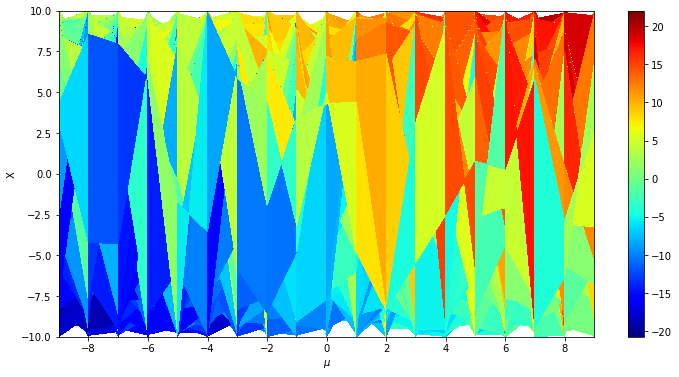

In [23]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')

mu_r = torch.arange(-100, 100, 1, dtype=torch.double)
x_r = y_sampler.x_dist.sample([1000, len(mu_r)]).double()

y_sampler.make_condition_sample({'mu': mu_r, 'X': x_r})
y = y_sampler.condition_sample()


plt.figure(figsize=(12,6))

mask = torch.abs(mu_r) < 10
plt.pcolormesh(mu_r[mask], x_r[:, mask], y[:, mask], cmap=my_cmap);
plt.colorbar()
plt.xlabel(r'$\mu$');
plt.ylabel("X");

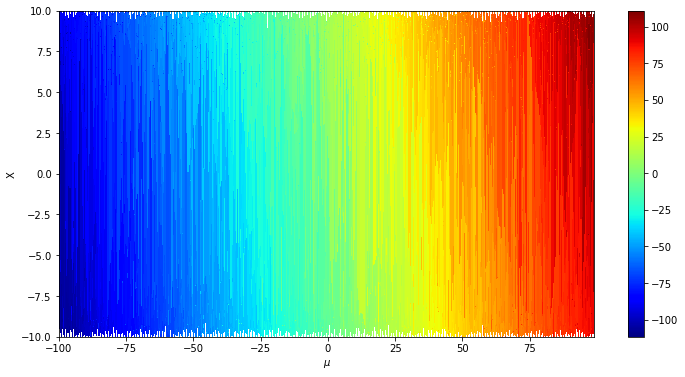

In [25]:
plt.figure(figsize=(12,6))
plt.pcolormesh(mu_r, x_r, y, cmap=my_cmap);
plt.colorbar()
plt.xlabel(r'$\mu$');
plt.ylabel("X");

## Statistic of interest

$$r = \frac{1}{N} \sum\limits_{i=0}^{N} || y_i - Y ||_2^2$$

In [3]:
from model import R

## Approaches to solve the problem

### First one

  1. Make approximation of this model:

  $$p(y | \mu)$$

  With GANs or some other techniques.
  

  2. Sample $\{ y_i \}_{i=0}^{B} \sim p(y | \mu)$
  
  
  3. Calc $r = R(\{ y_i \}_{i=0}^{B})$
  
  
  4. Find $\frac{\partial r}{\partial \mu}$
  
### Second one


  1. Make approximation of this model:

  $$p(r | \mu)$$
  
  
  2. Sample $r \sim p(r | \mu)$
  
  
  3. Find $\frac{\partial r}{\partial \mu}$

In [26]:
import numpy as np

rs = []
mus = np.linspace(-25, 25, 100)
for mu in tqdm.tqdm(mus):
    y_sampler.make_condition_sample({'mu': torch.tensor([mu] * 10000)})
    samples = y_sampler.condition_sample()
    rs.append(R(samples).item())

100%|██████████| 100/100 [00:00<00:00, 1008.69it/s]


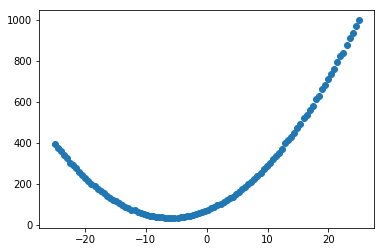

In [27]:
plt.scatter(mus, rs)

In [28]:
mus[np.argmin(rs)], np.min(rs)

(-5.808080808080806, 35.053306579589844)

In [248]:
rs = []
xs = np.linspace(-100, 100, 100)
for x in tqdm.tqdm(xs):
    y_sampler.make_condition_sample({'X': torch.tensor([x] * 10000)})
    samples = y_sampler.condition_sample()    
    rs.append(R(samples).item())

100%|██████████| 100/100 [00:00<00:00, 627.71it/s]


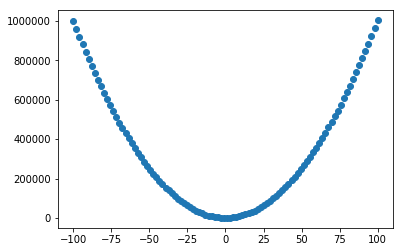

In [249]:
plt.scatter(xs, rs)

In [227]:
xs[np.argmin(rs)], np.min(rs)

/mnt/shirobokov/conda/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(-100.0, nan)